<a href="https://colab.research.google.com/github/mcampo26/map/blob/master/Project3eoutline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import necessary packages
!apt-get -qq install python-cartopy python3-cartopy
import cartopy
!pip install pykrige
# Now let's import packages
import pandas as pd
import matplotlib.pyplot as plt
import pylab #using as a plotting library for spatial data, make contours
import numpy as np #gridded datasets and matrices; array package

# import cartopy, which we will use to map
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features


# import the UniversalKriging function from pykrige.uk 
from pykrige.uk import UniversalKriging



In [0]:
!pip install pyproj

In [0]:
df = pd.read_excel('https://github.com/mcampo26/map/blob/master/FAKEpumpage.xlsx?raw=true') #read excel data

In [0]:
illimap= {'proj': 'lcc', # Lambert Conformal Conic
     'ellps': 'clrk66', #Clarke 1866 ellipsoid
     'lon_0': -89.5, #Central Meridian
     'lat_0': 33, #Latitude of Origin
     'lat_1': 33, #Standard Parallel 1
     'lat_2': 45, #Standard Parallel 2
     'x_0': 2999994*0.3048006096012192, #starting x-coord. in ft, python expects m
     'y_0': 0} #starting y-coord.

wgs84= Proj('epsg:4326') #Standard lat/long coordinates

In [27]:
Latitude=[] 
Longitude=[]
for index, row in df.iterrows():
  from pyproj import Proj, transform
  inProj = Proj(illimap) #define input projection
  outProj = wgs84 #define output projection
  Long1,Lat1 = (0.3048006096012192*row['lam_x'],0.3048006096012192*row['lam_y']) #define input coordinates; convert lambert ft to m
  Long2,Lat2 = transform(inProj,outProj,Long1,Lat1) #convert from lambert to wgs84
  Latitude.append(Lat2) #add latitude data to empty Latitude=[] array
  Longitude.append(Long2) #add longitude data to empty Longitude=[] array
df['Latitude']=Latitude
df['Longitude']=Longitude
df2=df.drop(['lam_x','lam_y'],axis=1)
print(df2)

    Pumpage 2018 (gallons/yr)  Pumpage 2019 (gallons/yr)   Latitude  Longitude
0                     4346400                       3750 -87.620953  41.405236
1                     1932000                      93000 -87.618318  41.397821
2                   372610000                     110000 -88.068302  41.599605
3                    77163000                    3687600 -88.078809  41.639464
4                    33228000                     198000 -87.642913  41.446744
5                   380355961                  301516000 -87.643012  41.443106
6                   346099000                     780000 -88.137381  41.502368
7                   166628000                  106710000 -87.615902  41.397783
8                   102275000                  317814000 -87.810466  41.485393
9                   109078000                  212898000 -88.116037  41.446905
10                  130566000                  200000000 -88.085560  41.611688
11                  137053000                   8503

In [0]:
#Domain of project
sw_lat = 41.411972 #southwest latitude
sw_long =  -88.241971 #southwest longitude
ne_lat =  41.72910 #northeast latitude
ne_long = -88.030337 #northeast longitude

In [0]:
minlat = 41
maxlat = 42
minlong = -88.75
maxlong = -87.5

In [0]:
# conduct the Universal Kriging
UK2018 = UniversalKriging(df2['Longitude'], df2['Latitude'], df2['Pumpage 2018 (gallons/yr)'], variogram_model='spherical',nlags=6)
UK2019 = UniversalKriging(df2['Longitude'], df2['Latitude'], df2['Pumpage 2019 (gallons/yr)'], variogram_model='spherical',nlags=6)

In [0]:
# create xpoints and ypoints in space, with 0.01 spacing
xpoints = np.arange(minlong,maxlong,0.01) 
ypoints = np.arange(minlat,maxlat,0.01) 

# create a meshgrid with xpoints and ypoints, to be used later in the code; same x or y points repeated in each line of X or Y grid
X,Y = np.meshgrid(xpoints,ypoints)

# calculate the interpolated grid and fill values (values in feet above mean sea level)
z18, var = UK2018.execute('grid', xpoints,ypoints)
z18 = z18.filled(fill_value=None)
z19, var = UK2019.execute('grid', xpoints,ypoints)
z19 = z19.filled(fill_value=None)

In [0]:
print(z18.min())
print(z18.max())
print(z19.min())
print(z19.max())

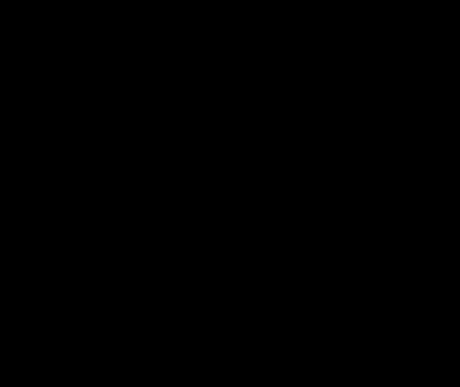

In [39]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xlim(minlong,maxlong)
ax.set_ylim(minlat,maxlat)
ax.set_title("Pumpage (gallons/yr)")
states_provinces = cf.NaturalEarthFeature(
    category='cultural', # features are categorized as cultural or physical
    name='admin_1_states_provinces', # name of shapefile
    scale='50m', # scale of features
    facecolor='none')	
largerivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines',
    scale='110m', # major rivers
    facecolor='none')
smallrivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines_scale_rank',
    scale='10m', # smaller rivers (still considered major by many/most people)
    facecolor='none')   
popplaces = cf.NaturalEarthFeature(
    category='cultural',
    name='urban_areas', # plots municipal boundaries
    scale='10m',
    facecolor='plum') 
# adds the features defined above
ax.add_feature(popplaces,edgecolor='plum',linewidth=1.0)
ax.add_feature(largerivers,edgecolor='aqua',linewidth=2.0)
ax.add_feature(smallrivers,edgecolor='aqua',linewidth=2.0)
ax.add_feature(states_provinces, edgecolor='black', linewidth=3.0,linestyle=':')

plt.scatter(X,Y, z18, marker=".", color="black", label="points")
plt.scatter(df2['Longitude'], df2['Latitude'], marker=".", color="black", label="points")
plt.legend(loc='lower right')
plt.fill()
plt.title('Pumpage 2018 (gallons/yr)')
plt.show()